# 01 - Wikipedia routes features integration
Author: **A. Salgas** (antoine.salgas@isae-supaero.fr)

This notebook is used to prepare the traffic estimation model.

To do so:

- Features are added to the wikipedia route database
- Open-source databases are imported and merged onto the wikipedia dataset (dependent variable)


In [1]:
# Import the necessary libraries

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 72

## Merge wikipedia routes and wikipedia airports withe features added

The routes database was created by parsing each airport destinations list on the wikipedia page (01_wikipedia_parser/02-routes_parsing.ipynb). Simultaneously, each airport informations were collected and completed afterwards (02_airport_features/airport_features_construction.ipynb).  
Now both databases are merged to add features to each route. 

In [2]:
enriched_airports_df=pd.read_csv('../02_airport_features/data/airport_with_all_features_26_09.csv', keep_default_na=False, na_values=['','NaN'], sep=',')

In [3]:
wiki_routes_df=pd.read_csv('../01_wikipedia_parser/data/wiki_route_db_26_09.csv', sep=',')

We also group the data without the airline info for the time beeing. 
The number of airlines operating on each route is counted, by relation type (Regular, Seasonnal, Charter).  
Routes are unoriented.

In [4]:
# Creating new columns with sorted origin and destination to have A->B = B->A (unoriented routes)
# Groupby tou count number of relations of each type between airports. 
# Indirect groupby have a similar count if the relation is present once or twice (ie A->B and B-> or only one)

wiki_routes_df_compact=wiki_routes_df.groupby(['origin','canonical_destination','type']).size().reset_index()
wiki_routes_df_compact[['sorted_origin','sorted_destination']] = wiki_routes_df_compact.apply(lambda x: sorted([x['origin'], x['canonical_destination']]), axis=1, result_type='expand')

def sum_divided_by_count(series):
    return series.sum() / series.count()


wiki_routes_df_compact=wiki_routes_df_compact.groupby(['sorted_origin','sorted_destination','type']).agg({0:sum_divided_by_count})

wiki_routes_df_compact=wiki_routes_df_compact.unstack(fill_value=0)

# Drop old columns on the original df
# wiki_routes_df.drop(columns=['sorted_origin','sorted_destination'], inplace=True)

In [5]:
wiki_routes_df_compact=wiki_routes_df_compact.reset_index()
wiki_routes_df_compact.columns=('sorted_origin','sorted_destination','Regular','Seasonal','Seasonal charter')

In [6]:
wiki_routes_df_compact

,sorted_origin,sorted_destination,Regular,Seasonal,Seasonal charter
0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,0.0,1.0,0.0
1,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,0.0,1.0,0.0
2,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Arland...,1.0,0.0,0.0
3,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Bromma...,1.0,0.0,0.0
4,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Visby_Airport,0.0,1.0,0.0
...,...,...,...,...,...
32852,https://en.wikipedia.org/wiki/Zhengzhou_Xinzhe...,https://en.wikipedia.org/wiki/Zunyi_Maotai_Air...,1.0,0.0,0.0
32853,https://en.wikipedia.org/wiki/Zhengzhou_Xinzhe...,https://en.wikipedia.org/wiki/Zunyi_Xinzhou_Ai...,1.0,0.0,0.0
32854,https://en.wikipedia.org/wiki/Zhuhai_Jinwan_Ai...,https://en.wikipedia.org/wiki/Zunyi_Maotai_Air...,2.0,0.0,0.0
32855,https://en.wikipedia.org/wiki/Zhuhai_Jinwan_Ai...,https://en.wikipedia.org/wiki/Zunyi_Xinzhou_Ai...,1.0,0.0,0.0


In [7]:
# Duplicating the airports database to add suffixes departure and origin

enriched_airports_deps = enriched_airports_df.add_suffix('_departure')
enriched_airports_arrs = enriched_airports_df.add_suffix('_arrival')

# Mergin airport data into the route database
routes_airports=wiki_routes_df_compact.merge(enriched_airports_deps, left_on='sorted_origin', right_on='wdpa_link_departure', how='left').merge(enriched_airports_arrs, left_on='sorted_destination', right_on='wdpa_link_arrival', how='left')

Dropping routes with wo airports match 
- Departure = NaN => it concerns only 0.1% of our data, so we'll ignore this.  

- Arrival = NaN, obviously, more airports are not in our database (despite performing a second iteration on airports found as destinations during wikipedia parsing that were not present in wikipedia airport list, we stopped at n=10 routes. Below, airports were not included). It concerns only 0.4 % of our data, so this is ignored as well.

In [8]:
routes_airports[['iata_departure','iata_arrival']].isna().sum()/len(routes_airports)

iata_departure    0.001216
iata_arrival      0.004301
dtype: float64

Above, the "consolidated pax" columns are not empty in 93% of the routes, which is a very good news! Even if on the airport database, the NaN frequency was higher (1/4 or so of our data), it concerned airport with a few routes, as it could have been expected. 

In [9]:
routes_airports.dropna(subset=['iata_departure','iata_arrival'] , inplace=True)

In [10]:
routes_airports.head()

,sorted_origin,sorted_destination,Regular,Seasonal,Seasonal charter,Unnamed: 0.1_departure,Unnamed: 0_departure,max_population_departure,max_passengers19_departure,maxpax_departure,wdpa_link_departure,lat_departure,lon_departure,iata_departure,icao_departure,ISO_country_departure,ISO_continent_departure,year_pax_round2_departure,pax_round2_departure,consolidated_pax_departure,h3_departure,pop_30k_departure,airport_30k_departure,pax_h3_30k_departure,pop_70k_departure,airport_70k_departure,pax_h3_70k_departure,pop_150k_departure,airport_150k_departure,pax_h3_150k_departure,GDP PPP_departure,Gini_departure,Surf_departure,toursim_export_share_departure,visiting_tourists_departure,outbound_tourists_departure,IHDI_departure,is_country_island_departure,Unnamed: 0.1_arrival,Unnamed: 0_arrival,max_population_arrival,max_passengers19_arrival,maxpax_arrival,wdpa_link_arrival,lat_arrival,lon_arrival,iata_arrival,icao_arrival,ISO_country_arrival,ISO_continent_arrival,year_pax_round2_arrival,pax_round2_arrival,consolidated_pax_arrival,h3_arrival,pop_30k_arrival,airport_30k_arrival,pax_h3_30k_arrival,pop_70k_arrival,airport_70k_arrival,pax_h3_70k_arrival,pop_150k_arrival,airport_150k_arrival,pax_h3_150k_arrival,GDP PPP_arrival,Gini_arrival,Surf_arrival,toursim_export_share_arrival,visiting_tourists_arrival,outbound_tourists_arrival,IHDI_arrival,is_country_island_arrival
0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,1557.0,1574.0,52980.0,473628.0,531305.0,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,63.194445,14.501944,OSD,ESNZ,SE,EU,2019.0,473628.0,473628.0,88081335c1fffff,5.745996e+04,1.0,473628.0,8.714590e+04,1.0,473628.0,1.508774e+05,1.0,473628.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0
1,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,3885.0,3918.0,6603.0,773.0,17961.0,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,61.159000,12.840000,SCR,ESKS,SE,EU,2019.0,773.0,773.0,8808a0b689fffff,7.866717e+03,1.0,773.0,3.672469e+04,1.0,773.0,4.829782e+05,6.0,28607467.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0
2,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Arland...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,1561.0,1578.0,978770.0,25642703.0,26846720.0,https://en.wikipedia.org/wiki/Stockholm_Arland...,59.651944,17.918611,ARN,ESSA,SE,EU,2019.0,25642703.0,25642703.0,88088621d5fffff,4.051383e+05,1.0,25642703.0,2.700008e+06,2.0,27996754.0,3.497674e+06,5.0,30453794.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0
3,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Bromma...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,190610

## Adding extra features to the route database

During the airport features compilation, only those related to an airport or a country could be added ((02_airport_features/airport_features_construction.ipynb). 
Now the features related to the relation itself are added.
- Bilateral trade flows (data from https://comtradeplus.un.org/TradeFlow)
- Distance
- Domestic or International

In [11]:
goods_flow=pd.read_csv('data/TradeData_GOODS.csv', sep=';', encoding = "ISO-8859-1")

# wee keep only the exports (if countries don't lie the imports of A from B are the exports of B to A, and flows will be transformed into bilateral flows (sum of both directions))

goods_flow=goods_flow[goods_flow['FlowCode']=='X']

synthetic_flows=goods_flow[['ReporterISO','ReporterDesc','PartnerISO','PartnerDesc','PrimaryValue']]
synthetic_flows.head()

,ReporterISO,ReporterDesc,PartnerISO,PartnerDesc,PrimaryValue
110,AFG,Afghanistan,W00,World,8.704885e+08
111,AFG,Afghanistan,AZE,Azerbaijan,6.254703e+04
112,AFG,Afghanistan,AUS,Australia,1.134984e+06
113,AFG,Afghanistan,AUT,Austria,3.800393e+05
114,AFG,Afghanistan,BHR,Bahrain,6.930802e+04


In [12]:
# Converting country codes from 3 digts ISO codes to 2 digits ISO codes (used in the route database)
country_code=pd.read_csv('data/country_codes.csv',  keep_default_na=False, na_values=['','NaN'])

a=synthetic_flows.merge(country_code[['Two_Letter_Country_Code','Three_Letter_Country_Code']], left_on='ReporterISO', right_on='Three_Letter_Country_Code', how='left')
a=a.rename(columns={'Two_Letter_Country_Code':'ISO-A'}).drop(columns={'Three_Letter_Country_Code'})

b=a.merge(country_code[['Two_Letter_Country_Code','Three_Letter_Country_Code']], left_on='PartnerISO', right_on='Three_Letter_Country_Code', how='left')
b=b.rename(columns={'Two_Letter_Country_Code':'ISO-B'}).drop(columns={'Three_Letter_Country_Code'})

trade_flow_prep=b.dropna(subset=['ISO-A','ISO-B'])[['ISO-A','ISO-B','PrimaryValue']].rename(columns={'PrimaryValue':'trade_value'})

In [13]:
# create a new column in each dataframe with sorted country names
trade_flow_prep['Countries'] = trade_flow_prep[['ISO-A', 'ISO-B']].apply(lambda x: '-'.join(sorted(x)), axis=1)
routes_airports['Countries'] = routes_airports[['ISO_country_departure', 'ISO_country_arrival']].apply(lambda x: '-'.join(sorted(x)), axis=1)

# Sum A->B flow with B->A flow
trade_flow_prep=trade_flow_prep.groupby('Countries', as_index=True)['trade_value'].sum()

# merge the two dataframes based on the sorted country names
routes_airports = pd.merge(routes_airports, trade_flow_prep, on='Countries', how='left')
routes_airports.drop(columns={'Countries'}, inplace=True)

#drop duplicates if any 
routes_airports.drop_duplicates(subset=['iata_departure','iata_arrival'], inplace=True)

In [14]:
routes_airports.head()

,sorted_origin,sorted_destination,Regular,Seasonal,Seasonal charter,Unnamed: 0.1_departure,Unnamed: 0_departure,max_population_departure,max_passengers19_departure,maxpax_departure,wdpa_link_departure,lat_departure,lon_departure,iata_departure,icao_departure,ISO_country_departure,ISO_continent_departure,year_pax_round2_departure,pax_round2_departure,consolidated_pax_departure,h3_departure,pop_30k_departure,airport_30k_departure,pax_h3_30k_departure,pop_70k_departure,airport_70k_departure,pax_h3_70k_departure,pop_150k_departure,airport_150k_departure,pax_h3_150k_departure,GDP PPP_departure,Gini_departure,Surf_departure,toursim_export_share_departure,visiting_tourists_departure,outbound_tourists_departure,IHDI_departure,is_country_island_departure,Unnamed: 0.1_arrival,Unnamed: 0_arrival,max_population_arrival,max_passengers19_arrival,maxpax_arrival,wdpa_link_arrival,lat_arrival,lon_arrival,iata_arrival,icao_arrival,ISO_country_arrival,ISO_continent_arrival,year_pax_round2_arrival,pax_round2_arrival,consolidated_pax_arrival,h3_arrival,pop_30k_arrival,airport_30k_arrival,pax_h3_30k_arrival,pop_70k_arrival,airport_70k_arrival,pax_h3_70k_arrival,pop_150k_arrival,airport_150k_arrival,pax_h3_150k_arrival,GDP PPP_arrival,Gini_arrival,Surf_arrival,toursim_export_share_arrival,visiting_tourists_arrival,outbound_tourists_arrival,IHDI_arrival,is_country_island_arrival,trade_value
0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,1557.0,1574.0,52980.0,473628.0,531305.0,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,63.194445,14.501944,OSD,ESNZ,SE,EU,2019.0,473628.0,473628.0,88081335c1fffff,5.745996e+04,1.0,473628.0,8.714590e+04,1.0,473628.0,1.508774e+05,1.0,473628.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN
1,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,3885.0,3918.0,6603.0,773.0,17961.0,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,61.159000,12.840000,SCR,ESKS,SE,EU,2019.0,773.0,773.0,8808a0b689fffff,7.866717e+03,1.0,773.0,3.672469e+04,1.0,773.0,4.829782e+05,6.0,28607467.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN
2,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Arland...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,1561.0,1578.0,978770.0,25642703.0,26846720.0,https://en.wikipedia.org/wiki/Stockholm_Arland...,59.651944,17.918611,ARN,ESSA,SE,EU,2019.0,25642703.0,25642703.0,88088621d5fffff,4.051383e+05,1.0,25642703.0,2.700008e+06,2.0,27996754.0,3.497674e+06,5.0,30453794.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN
3,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Bromma...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4

In [15]:
# Computing route great circle distance
from geopy import distance
routes_airports.loc[:, "distance_km"] = routes_airports.progress_apply(
    lambda x: distance.distance((float(x.lat_departure), float(x.lon_departure)),
                                (float(x.lat_arrival), float(x.lon_arrival))).km, axis=1)


  0%|          | 0/32652 [00:00<?, ?it/s]

In [16]:
# Adding a bool domestic/international

routes_airports['domestic']=(routes_airports.ISO_country_arrival == routes_airports.ISO_country_departure).astype(int)

## Adding the dependent variable references

### BTS - Bureau of transportation statistics

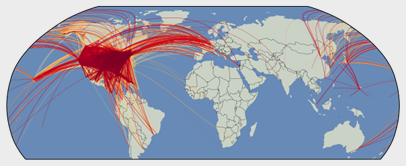

The BTS data was already processed and used widely for https://arc.aiaa.org/doi/10.2514/6.2023-1357.

The data is open-source and available at https://www.transtats.bts.gov/ ("Form 41" -> database "T-100 Segment")

The data preprocessing is done in a python file, originally created for another project, stored in 'Utilities'.

In [17]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/Utilities")

import us_bts 
import flights

In [19]:
bts_flights_2019=us_bts.FlightBts()
bts_flights_2019.load_new_file('data/BTS/T_T100_SEGMENT_ALL_CARRIER_2019.csv',1)
bts_flights_2019.preprocess_data()

Size of df at begining 487923
Size of df after adding aircraft info 487923, number of flights: 11133316.0
Size of df after grouping 116724; number flights 11133316.0
Size of df after airports process 116724; number flights 11133316.0


For the sake of simplicity in this schedule estimation part, the data is agregated at the route level. We're loosing the information on the airline and the aircraft type. Note however that in the final dataset, these info will be included when available. 

The airport designation is somehow bothersome in the US BTS sytem. The code used is a three letter code, equal to IATA code when available and including digits when unavailable. 
We aggregate the data so that A -> B is the same as B -> A

In [20]:
simplified_bts=bts_flights_2019.df.groupby(['origin_iata','dest_iata'])['seats'].sum().reset_index()

# create new column with sorted tuples of values in col1 and col2
simplified_bts['group_col'] = simplified_bts[['origin_iata', 'dest_iata']].apply(lambda x: tuple(sorted(x)), axis=1)
# group by the new column
grouped = simplified_bts.groupby(['group_col'])['seats'].sum().reset_index()

routes_airports['group_col'] = routes_airports[['iata_departure', 'iata_arrival']].apply(lambda x: tuple(sorted(x)), axis=1)

In [21]:
merge_test=pd.merge(routes_airports, grouped, on=['group_col'], how='inner')

print('Seats of BTS data (2019) covered by wikipedia parsing (2023): {:.1f} %'.format(merge_test['seats'].sum()/grouped['seats'].sum()*100))

Seats of BTS data (2019) covered by wikipedia parsing (2023): 96.7 %


This value is very important and interesting: the destination list of wikipedia was parsed in april 2023, meaning that some destinations are new and some other were deleted compared to 2019. This indicator shows that few of them were discontinued, or at least not busy routes. 


The other figured can be investigated (filter df on US orig or dest flights, left merge and count NaN):

In [22]:
routes_airports_us=routes_airports[(routes_airports['ISO_country_departure']=='US') | (routes_airports['ISO_country_arrival']=='US')]
nbna=pd.merge(routes_airports_us, grouped, on=['group_col'], how='left')['seats'].isna().sum()
nbtot=len(routes_airports_us)

print('Flight of wiki parsing (2023) not in bts 2019 data: {:.1f} %'.format(nbna/nbtot * 100))

Flight of wiki parsing (2023) not in bts 2019 data: 9.7 %


This value is more significant, suggesting a route number increase. Comparing to 2022 bts data would be insightfull, but is beyond the accuracy target of this work. It should be remineded that the estimation will be used only on routes where data is not already available. It is not the case of routes to/from USA.

<ins>Finnaly, the actual merge<ins/>:

In [23]:
routes_with_bts=pd.merge(routes_airports, grouped, on=['group_col'], how='left').rename(columns={'seats':'BTS_seats'})
routes_with_bts.head()

,sorted_origin,sorted_destination,Regular,Seasonal,Seasonal charter,Unnamed: 0.1_departure,Unnamed: 0_departure,max_population_departure,max_passengers19_departure,maxpax_departure,wdpa_link_departure,lat_departure,lon_departure,iata_departure,icao_departure,ISO_country_departure,ISO_continent_departure,year_pax_round2_departure,pax_round2_departure,consolidated_pax_departure,h3_departure,pop_30k_departure,airport_30k_departure,pax_h3_30k_departure,pop_70k_departure,airport_70k_departure,pax_h3_70k_departure,pop_150k_departure,airport_150k_departure,pax_h3_150k_departure,GDP PPP_departure,Gini_departure,Surf_departure,toursim_export_share_departure,visiting_tourists_departure,outbound_tourists_departure,...,max_population_arrival,max_passengers19_arrival,maxpax_arrival,wdpa_link_arrival,lat_arrival,lon_arrival,iata_arrival,icao_arrival,ISO_country_arrival,ISO_continent_arrival,year_pax_round2_arrival,pax_round2_arrival,consolidated_pax_arrival,h3_arrival,pop_30k_arrival,airport_30k_arrival,pax_h3_30k_arrival,pop_70k_arrival,airport_70k_arrival,pax_h3_70k_arrival,pop_150k_arrival,airport_150k_arrival,pax_h3_150k_arrival,GDP PPP_arrival,Gini_arrival,Surf_arrival,toursim_export_share_arrival,visiting_tourists_arrival,outbound_tourists_arrival,IHDI_arrival,is_country_island_arrival,trade_value,distance_km,domestic,group_col,BTS_seats
0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,52980.0,473628.0,531305.0,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,63.194445,14.501944,OSD,ESNZ,SE,EU,2019.0,473628.0,473628.0,88081335c1fffff,5.745996e+04,1.0,473628.0,8.714590e+04,1.0,473628.0,1.508774e+05,1.0,473628.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,774.017747,1,"(AGH, OSD)",NaN
1,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,6603.0,773.0,17961.0,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,61.159000,12.840000,SCR,ESKS,SE,EU,2019.0,773.0,773.0,8808a0b689fffff,7.866717e+03,1.0,773.0,3.672469e+04,1.0,773.0,4.829782e+05,6.0,28607467.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,541.678318,1,"(AGH, SCR)",NaN
2,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Arland...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,978770.0,25642703.0,26846720.0,https://en.wikipedia.org/wiki/Stockholm_Arland...,59.651944,17.918611,ARN,ESSA,SE,EU,2019.0,25642703.0,25642703.0,88088621d5fffff,4.051383e+05,1.0,25642703.0,2.700008e+06,2.0,27996754.0,3.497674e+06,5.0,30453794.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,478.768770,1,"(AGH, ARN)",NaN
3,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Bromma...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,

### Eurocontrol R&D

Eurocontrol R&D data is available on https://ext.eurocontrol.int/.

This data wasn't used previously with like for BTS data, therefore the preprocessing is done below.  
The data is discosed in monthly data chunks, 4 month per year are given. It doesn't matter, we are interested in trends, and these 4 months provide a good overview of the year, and figures that are probably close to reality.

The data is actually not aggregated at all, meaning that we have every single flight. 

Processing steps required:

- filter to on statfor market segment to keep only commercial passenger flights
- adding a number of seats for each flight using the aircrfat type average
- group by origin-destination pair and count the seats
- convert airport ICAO code to IATA code  

In [24]:
# Load the data chunks
ectrl_1=pd.read_csv('data/Eurocontrol/Flights_20190301_20190331.csv')
ectrl_2=pd.read_csv('data/Eurocontrol/Flights_20190601_20190630.csv')
ectrl_3=pd.read_csv('data/Eurocontrol/Flights_20190901_20190930.csv')
ectrl_4=pd.read_csv('data/Eurocontrol/Flights_20191201_20191231.csv')

ectrl=pd.concat([ectrl_1,ectrl_2,ectrl_3,ectrl_4])

In [25]:
# Keep only the commercial passenger flights
ectrl=ectrl[ectrl.loc[:,'STATFOR Market Segment'].isin(['Traditional Scheduled', 'Lowcost', 'Charter'])]

There are 175 aircraft in the data, after filtering only for scheduled or charter flights (Most cargo should be removed). Finding the seats for each one of them could be bothersome, meaning we limit that to those making up 98% of the flights.

Text(58, 87, 'n_aircraft for 98%: 58 ')

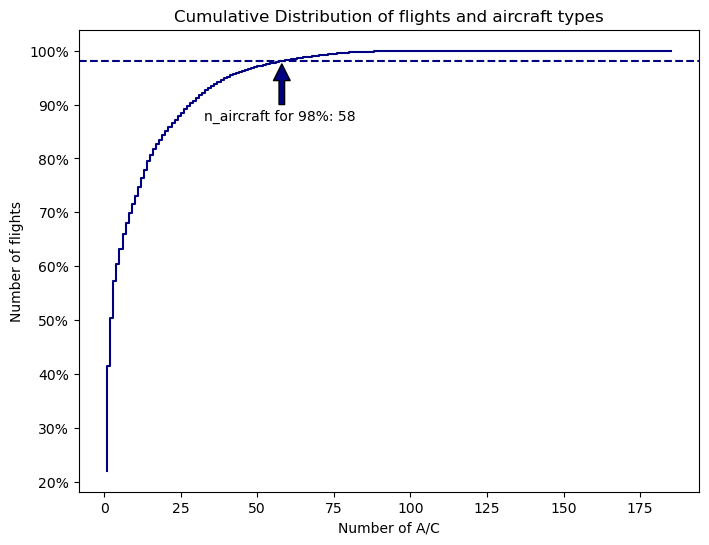

In [26]:
import matplotlib.ticker as mtick
pd.options.display.max_rows = 200
counts=ectrl['AC Type'].value_counts()
cumul=counts.cumsum()/counts.sum()
count_index = range(1, len(counts)+1)

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=count_index, y=cumul.values*100, drawstyle='steps', color='navy', ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Set plot title and labels
plt.title('Cumulative Distribution of flights and aircraft types')
plt.xlabel('Number of A/C')
plt.ylabel('Number of flights')

# Find index count at which the cumulative values reach 98%
index_98_percent = cumul.searchsorted(0.98, side='left') + 1

# Add horizontal dotted line at 98% threshold
ax.axhline(y=98, linestyle='--', color='navy')

# Add annotation for index value
ax.annotate("n_aircraft for 98%: {} ".format(index_98_percent), xy=(index_98_percent, 98), xytext=(index_98_percent, 87),
            arrowprops=dict(facecolor='navy', shrink=0.05), ha='center')

In [27]:
# Keep only the 58 most frequent aircraft type flights

ac_filter=list(counts.nlargest(58).index)
ectrl_filtered=ectrl[ectrl['AC Type'].isin(ac_filter)]

# Remove some cargo airlines taht were present despite filtering
ectrl_filtered=ectrl_filtered[~ectrl_filtered['AC Operator'].isin(['FDX','UPS','CLX','GTI','CKS','ABW'])]

Now let's match this list of aircraft with those present in the planespotters database (https://www.planespotters.net/)
The spotter db uses names to store the aircraft instead of ICAO codes. A manual match is created (even more reason to limit to the most flow aircraft).  
Three exceptions are not in the planesportter db. An helicopter, the beech 1900 (19pax) and a Business Jet (Cessna C68A) (having performed "charter" missions).  
We perfrom a right match on the fleet db to keep only the aircraft type in the said list.

In [29]:
fleet=pd.read_excel('data/planespotters_fleet.xlsx')
fleet['Seat Total']=fleet['Seat Total'].replace(0, np.nan)
fleet.dropna(subset=['Seat Total'], inplace=True)

# Adding the name/icao code match table
match=pd.read_csv('data/fleet_match.csv', sep=';')
fleet=fleet.merge(match, left_on='Aircraft Type', right_on='spotter_name', how='right').drop(columns='spotter_name')

to_ectrl=fleet.groupby(['Aircraft Type','ICAO_AC'])['Seat Total'].mean().reset_index().drop(columns='Aircraft Type')
ectrl_filtered=ectrl_filtered.merge(to_ectrl, left_on='AC Type', right_on='ICAO_AC', how='left')

In [30]:
# Save the eurocontrol file for usage in the production notebook (03_routes_schedule/03_routes_product.ipynb)
ectrl_filtered.to_csv('data/ectrl_to_prod_ipynb.csv')

In [31]:
# Grouping the flughts per route and multiplying the total seat number by 3 (we only have 4 month of data)
ectrl_filtered=ectrl_filtered.groupby(['ADEP','ADES'])['Seat Total'].agg(['sum','count']).reset_index()
ectrl_filtered[['sum','count']]=ectrl_filtered[['sum','count']]*3

ICAO codes of airports are used in the Eurocontrol Dataset. By airport database contrcution, we rather use IATA codes and use ourairports database (https://ourairports.com/data/)

In [32]:
airport_db=pd.read_csv('data/ourairports.csv', sep=';')
airport_db_match=airport_db[['ident','iata_code']]

# merging airport IATA codes 
ectrl_dep=ectrl_filtered.merge(airport_db_match,left_on='ADEP',right_on='ident', how='left').rename(columns={'iata_code':'iata_departure'})
ectrl_arr=ectrl_dep.merge(airport_db_match,left_on='ADES',right_on='ident', how='left').rename(columns={'iata_code':'iata_arrival'})

There are of course NaN resulting of the match, but they represent 0.1% of the seats. They could be from airports with no iata code, probably in flight filed flight plans/or unknown 'ZZZZ' icao code.

In [33]:
print('Percentage of seats with no match dep: {} %'.format(ectrl_arr[ectrl_arr['ident_x'].isna()]['sum'].sum()/ectrl_arr['sum'].sum()*100))
print('Percentage of seats with no match arr: {} %'.format(ectrl_arr[ectrl_arr['ident_y'].isna()]['sum'].sum()/ectrl_arr['sum'].sum()*100))


Percentage of seats with no match dep: 0.11009255317954031 %
Percentage of seats with no match arr: 0.10685626357259188 %


In [34]:
ectrl_ok=ectrl_arr.dropna(subset=['iata_departure','iata_arrival']).drop(columns=['ADEP','ADES','ident_x','ident_y']).rename(columns={'sum':'seats'})

In [35]:
#now same procedure as BTS file -> city pair

# create new column with sorted tuples of values in col1 and col2
ectrl_ok['group_col'] = ectrl_ok[['iata_departure', 'iata_arrival']].apply(lambda x: tuple(sorted(x)), axis=1)

# group by the new column
grouped = ectrl_ok.groupby(['group_col'])['seats'].sum().reset_index()

In [36]:
merge_test=pd.merge(routes_airports, grouped, on=['group_col'], how='inner')

print('Seats* of Eurocontrol R&D data (2019) covered by wikipedia parsing (2023): {:.1f} %'.format(merge_test['seats'].sum()/grouped['seats'].sum()*100))

Seats* of Eurocontrol R&D data (2019) covered by wikipedia parsing (2023): 88.2 %


More mismatch than for US BTS, meaning that some routes in europe flown in 2019 were not found by the wikipedia parsing. This is once again not a problem since Eurocontrol R&D data will be directly used for this geography in the "production" dataset.

In [37]:
# Merge on the wiki dataset
routes_with_bts_ecrl=pd.merge(routes_with_bts, grouped, on=['group_col'], how='left').rename(columns={'seats':'ECRL_seats'})

### OpenSky

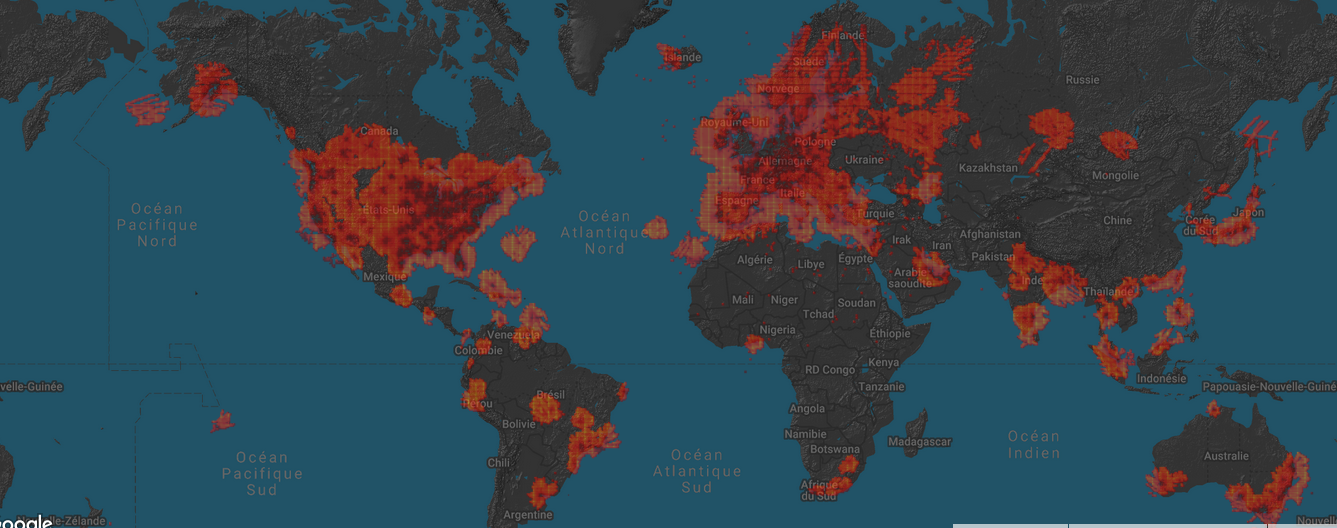

New data source: https://opensky-network.org/

In [38]:
# New import to use opensky data preprocessing script
import open_sky


In [40]:
## Pretty long due to the unaggregate nature of the flight entries.

os_flights_2019=open_sky.FlightOpenSky()
os_flights_2019.load_new_file('data/open_sky/zenodo_flightlist_1000ft.csv',1) # ==> the file was extracted from opensky zenodo archive with a notebook that can be found in Utilities folder
os_flights_2019.preprocess_data()


1.9261187728109495% of flights deleted after removing flights with no origin and destination. 12096153 Flights in the dataset


C:\Users\a.salgas.ISAE-SUPAERO\PycharmProjects\AirTraffic\TrafficEstimator/Utilities\open_sky.py:51: DtypeWarning: Columns (4,5,17,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  ac_ref = pd.read_csv(data_path, sep=',')


Size of df after_grouping: 1248426; number of flights: 12096153
Size of df after ac info: 1248426; number of flights 12096153
Size of df after arpt info: 1242454, number of flights: 12043034


In [41]:
os_df=os_flights_2019.df

## Filter only the commercial aircraft type (remive helicopters, piston, private jet,...)
os_df=os_df[os_df['acft_class'].isin(['NB', 'WB', 'RJ','TP'])]

Text(97, 87, 'n_aircraft for 98%: 97 ')

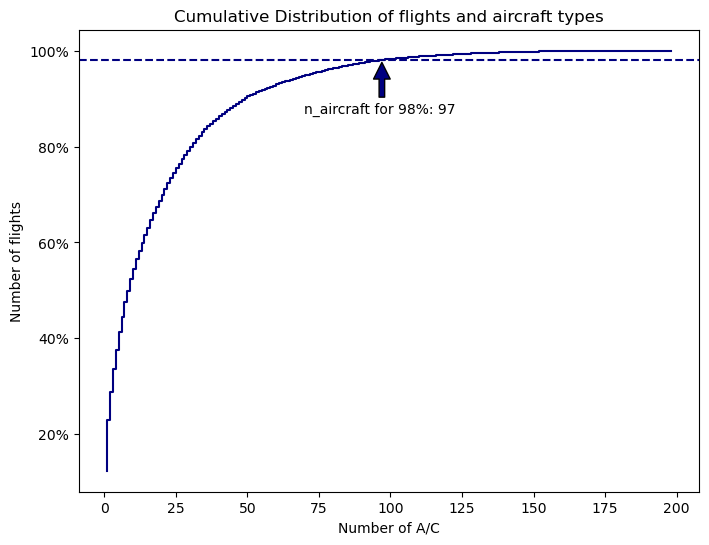

In [42]:
## Similarly to Eurocontrol dataset, we look at how many aircraft types are necessary to reach 98% of the flights. 
## Then we'll add the average number of seats for this aircraft type to compute route ask.

pd.options.display.max_rows = 200
counts=os_df['acft_icao'].value_counts()
cumul=counts.cumsum()/counts.sum()
count_index = range(1, len(counts)+1)

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(x=count_index, y=cumul.values*100, drawstyle='steps', color='navy', ax=ax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Set plot title and labels
plt.title('Cumulative Distribution of flights and aircraft types')
plt.xlabel('Number of A/C')
plt.ylabel('Number of flights')

# Find index count at which the cumulative values reach 98%
index_98_percent = cumul.searchsorted(0.98, side='left') + 1

# Add horizontal dotted line at 98% threshold
ax.axhline(y=98, linestyle='--', color='navy')

# Add annotation for index value
ax.annotate("n_aircraft for 98%: {} ".format(index_98_percent), xy=(index_98_percent, 98), xytext=(index_98_percent, 87),
            arrowprops=dict(facecolor='navy', shrink=0.05), ha='center')

In [43]:
ac_filter=list(counts.nlargest(97).index)
os_filtered=os_df[os_df['acft_icao'].isin(ac_filter)]

Similarly to what was done with eurocontrol data, the fleet match list was extended with a few additional aircraft types for whcih a seat count was found.  
Note that the flights of *os_filtered* contains private flights, made by turboprops private planes (PC-12, TBM, etc). Indeed all turboprops were classified together, which is unpractical for this application.   
Another flaw is that there are no easy way to guess if a given flight is a dedicated cargo flight or a passenger flight. To be completely rigorous, it would be necessary to make a list of the cargo airlines. Still, I remove the flights of some of the biggest all-cargo airlines. 

In [44]:
os_filtered=os_filtered[~os_filtered['airline_iata'].isin(['FDX','UPS','CLX','GTI','CKS','ABW'])]
os_filtered=os_filtered.merge(to_ectrl, left_on='acft_icao', right_on='ICAO_AC', how='left')
os_filtered['Seat Total']=os_filtered['n_flights']*os_filtered['Seat Total']
os_filtered=os_filtered.groupby(['origin_iata','dest_iata','airline_iata','acft_icao','acft_class','seymour_proxy'])[['Seat Total','n_flights']].sum().reset_index().rename(columns={'Seat Total':'seats'})

In [45]:
# Save the opensky file for usage in the production notebook (03_routes_schedule/03_routes_product.ipynb)
os_filtered.to_csv('data/osky_to_prod_1000ft.csv')

In [46]:
#now same procedure as BTS file -> city pair

# create new column with sorted tuples of values in col1 and col2
os_filtered['group_col'] = os_filtered[['origin_iata', 'dest_iata']].apply(lambda x: tuple(sorted(x)), axis=1)

# group by the new column
grouped = os_filtered.groupby(['group_col'])['seats'].sum().reset_index()

In [47]:
merge_test=pd.merge(routes_airports, grouped, on=['group_col'], how='inner')

print('Seats* of OpenSky data (2019) covered by wikipedia parsing (2023): {:.1f} %'.format(merge_test['seats'].sum()/grouped['seats'].sum()*100))

Seats* of OpenSky data (2019) covered by wikipedia parsing (2023): 86.3 %


In [48]:
routes_with_bts_ecrl_os=pd.merge(routes_with_bts_ecrl, grouped, on=['group_col'], how='left').rename(columns={'seats':'osky_seats'})

### WorldBank CityPairs


The world bank provides a database of airport-pairs flows, and number of seats offered, for international routes. The data format is much simpler to handle than the 3 previous datasets.

https://datacatalog.worldbank.org/search/dataset/0038117/Global-Airports

Data is for 2019 or most recent value before that.

In [49]:
worldbank_df=pd.read_csv('data/world_bank_airport_flows.csv', sep=';')

worldbank_df=worldbank_df[['Orig','Dest','TotalSeats']]
worldbank_df.nlargest(10,columns='TotalSeats')

,Orig,Dest,TotalSeats
31605,TPE,HKG,3706664.850
14069,HKG,TPE,3704905.652
6276,CGK,SIN,2799945.603
28382,SIN,CGK,2799945.603
17490,KUL,SIN,2764137.691
28454,SIN,KUL,2726618.244
13930,HKG,BKK,2288547.611
15757,JFK,LHR,2228076.263
14045,HKG,PVG,2198975.835
26437,PVG,HKG,2198490.539


In [50]:
worldbank_df['group_col'] = worldbank_df[['Orig', 'Dest']].apply(lambda x: tuple(sorted(x)), axis=1)

# group by the new column
grouped = worldbank_df.groupby(['group_col'])['TotalSeats'].sum().reset_index()

In [51]:
merge_test=pd.merge(routes_airports, grouped, on=['group_col'], how='inner')

print('Seats of WorldBank data (2019) covered by wikipedia parsing (2023): {:.1f} %'.format(merge_test['TotalSeats'].sum()/grouped['TotalSeats'].sum()*100))

Seats of WorldBank data (2019) covered by wikipedia parsing (2023): 90.7 %


In [52]:
routes_with_bts_ecrl_os_wb=pd.merge(routes_with_bts_ecrl_os, grouped, on=['group_col'], how='left').rename(columns={'TotalSeats':'wb_seats'})

In [53]:
routes_with_bts_ecrl_os_wb.head()

,sorted_origin,sorted_destination,Regular,Seasonal,Seasonal charter,Unnamed: 0.1_departure,Unnamed: 0_departure,max_population_departure,max_passengers19_departure,maxpax_departure,wdpa_link_departure,lat_departure,lon_departure,iata_departure,icao_departure,ISO_country_departure,ISO_continent_departure,year_pax_round2_departure,pax_round2_departure,consolidated_pax_departure,h3_departure,pop_30k_departure,airport_30k_departure,pax_h3_30k_departure,pop_70k_departure,airport_70k_departure,pax_h3_70k_departure,pop_150k_departure,airport_150k_departure,pax_h3_150k_departure,GDP PPP_departure,Gini_departure,Surf_departure,toursim_export_share_departure,visiting_tourists_departure,outbound_tourists_departure,...,wdpa_link_arrival,lat_arrival,lon_arrival,iata_arrival,icao_arrival,ISO_country_arrival,ISO_continent_arrival,year_pax_round2_arrival,pax_round2_arrival,consolidated_pax_arrival,h3_arrival,pop_30k_arrival,airport_30k_arrival,pax_h3_30k_arrival,pop_70k_arrival,airport_70k_arrival,pax_h3_70k_arrival,pop_150k_arrival,airport_150k_arrival,pax_h3_150k_arrival,GDP PPP_arrival,Gini_arrival,Surf_arrival,toursim_export_share_arrival,visiting_tourists_arrival,outbound_tourists_arrival,IHDI_arrival,is_country_island_arrival,trade_value,distance_km,domestic,group_col,BTS_seats,ECRL_seats,osky_seats,wb_seats
0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,63.194445,14.501944,OSD,ESNZ,SE,EU,2019.0,473628.0,473628.0,88081335c1fffff,5.745996e+04,1.0,473628.0,8.714590e+04,1.0,473628.0,1.508774e+05,1.0,473628.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,774.017747,1,"(AGH, OSD)",NaN,NaN,NaN,NaN
1,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,61.159000,12.840000,SCR,ESKS,SE,EU,2019.0,773.0,773.0,8808a0b689fffff,7.866717e+03,1.0,773.0,3.672469e+04,1.0,773.0,4.829782e+05,6.0,28607467.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,541.678318,1,"(AGH, SCR)",NaN,841.650955,NaN,NaN
2,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Arland...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,https://en.wikipedia.org/wiki/Stockholm_Arland...,59.651944,17.918611,ARN,ESSA,SE,EU,2019.0,25642703.0,25642703.0,88088621d5fffff,4.051383e+05,1.0,25642703.0,2.700008e+06,2.0,27996754.0,3.497674e+06,5.0,30453794.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,478.768770,1,"(AGH, ARN)",NaN,315686.818350,151019.460709,NaN
3,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Bromma...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,https://en.wikipedia.o

### ANAC

Anac is the civil aviation authorithy of Brasil, and lists all the routes in a very similar way as WorldBank data.

https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/dados-estatisticos  

However, the airports are registered with their ICAO codes.

In [54]:
brasil_df=pd.read_csv('data/brasil_flights.csv', sep=';', encoding='ANSI')

#Retriction to routes actually serving brasil 

brasil_df = brasil_df[~((brasil_df['AEROPORTO DE DESTINO (PAÍS)'] != 'BRASIL') & (brasil_df['AEROPORTO DE ORIGEM (PAÍS)'] != 'BRASIL'))]

brasil_df.head()

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MÊS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIÃO),AEROPORTO DE ORIGEM (PAÍS),AEROPORTO DE ORIGEM (CONTINENTE),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE DESTINO (REGIÃO),AEROPORTO DE DESTINO (PAÍS),AEROPORTO DE DESTINO (CONTINENTE),NATUREZA,GRUPO DE VOO,PASSAGEIROS PAGOS,PASSAGEIROS GRÁTIS,CARGA PAGA (KG),CARGA GRÁTIS (KG),CORREIO (KG),ASK,RPK,ATK,RTK,COMBUSTÍVEL (LITROS),DISTÂNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,AAF,AIGLE AZUR,ESTRANGEIRA,2019,1,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,EUROPA,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,NÃO REGULAR,3118.0,0.0,98305.0,0.0,0.0,43008700.0,29203200.0,7212640.0,3549000.0,NaN,149856.0,16.0,920725000.0,0.0,0.0,4592.0,770089.0,"144,86",NaN
1,AAF,AIGLE AZUR,ESTRANGEIRA,2019,1,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,EUROPA,INTERNACIONAL,NÃO REGULAR,4051.0,0.0,28155.0,2694.0,0.0,43008700.0,37941700.0,7212640.0,3678440.0,NaN,149856.0,16.0,263700000.0,25232000.0,0.0,4592.0,770089.0,"227,34",NaN
2,AAF,AIGLE AZUR,ESTRANGEIRA,2019,2,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,EUROPA,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,NÃO REGULAR,3141.0,0.0,65895.0,0.0,0.0,43008700.0,29418600.0,7212640.0,3264840.0,NaN,149856.0,16.0,617173000.0,0.0,0.0,4592.0,770089.0,"107,35",NaN
3,AAF,AIGLE AZUR,ESTRANGEIRA,2019,2,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,EUROPA,INTERNACIONAL,NÃO REGULAR,3269.0,0.0,0.0,0.0,0.0,43008700.0,30617500.0,7212640.0,2755560.0,NaN,149856.0,16.0,0.0,0.0,0.0,4592.0,770089.0,"267,29",NaN
4,AAF,AIGLE AZUR,ESTRANGEIRA,2019,3,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,EUROPA,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,NÃO REGULAR,2877.0,0.0,99619.0,0.0,0.0,45696700.0,26946000.0,11728800.0,3358160.0,NaN,159222.0,17.0,933032000.0,0.0,0.0,4879.0,1252270.0,"134,73",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37841,WGN,WESTERN GLOBAL AIRLINES,ESTRANGEIRA,2019,10,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,NÃO REGULAR,0.0,0.0,103660.0,0.0,0.0,0.0,0.0,1007550.0,696284.0,NaN,13434.0,2.0,696284000.0,0.0,0.0,0.0,150000.0,"16,67",NaN
37843,WGN,WESTERN GLOBAL AIRLINES,ESTRANGEIRA,2019,10,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,INTERNACIONAL,IMPRODUTIVO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,503775.0,0.0,NaN,6717.0,1.0,0.0,0.0,0.0,0.0,75000.0,"8,25",NaN
37844,WGN,WESTERN GLOBAL AIRLINES,ESTRANGEIRA,2019,10,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,IMPRODUTIVO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,398.0,1.0,0.0,0.0,0.0,0.0,0.0,"1,42",NaN
37845,WGN,WESTERN GLOBAL AIRLINES,ESTRANGEIRA,2019,10,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,KMIA,"MIAMI, FLORIDA",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,INTERNACIONAL,NÃO REGULAR,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# merging airport IATA codes 
brasil_dep=brasil_df.merge(airport_db_match,left_on='AEROPORTO DE ORIGEM (SIGLA)',right_on='ident', how='left').rename(columns={'iata_code':'iata_departure'})
brasil_arr=brasil_dep.merge(airport_db_match,left_on='AEROPORTO DE DESTINO (SIGLA)',right_on='ident', how='left').rename(columns={'iata_code':'iata_arrival'})

In [56]:
brasil_df=brasil_arr[['iata_departure', 'iata_arrival','ASSENTOS', 'EMPRESA (SIGLA)']].dropna(subset=['iata_departure','iata_arrival']).rename(columns={'ASSENTOS':'seats','EMPRESA (SIGLA)':'airline'})

In [57]:
#now same procedure as BTS file -> city pair

# create new column with sorted tuples of values in col1 and col2
brasil_df['group_col'] = brasil_df[['iata_departure', 'iata_arrival']].apply(lambda x: tuple(sorted(x)), axis=1)

# group by the new column
grouped = brasil_df.groupby(['group_col'])['seats'].sum().reset_index()

In [58]:
brasil_df.to_csv('data/brasil_to_prod.csv')

In [59]:
# Merge on the wiki dataset
routes_with_bts_ecrl_os_wb_br=pd.merge(routes_with_bts_ecrl_os_wb, grouped, on=['group_col'], how='left').rename(columns={'seats':'ANAC_seats'})

### Australian statistics 
https://www.bitre.gov.au/publications/ongoing/domestic_airline_activity-time_series


In [60]:
australia_df=pd.read_excel('data/australia_flights.xlsx')
australia_df=australia_df.rename(columns={'City Pair Route':'iata_departure','Unnamed: 1':'iata_arrival','Seats':'seats'})
australia_df=australia_df[['iata_departure','iata_arrival','seats']]

In [61]:
#now same procedure as BTS file -> city pair

# create new column with sorted tuples of values in col1 and col2
australia_df['group_col'] = australia_df[['iata_departure', 'iata_arrival']].apply(lambda x: tuple(sorted(x)), axis=1)

# group by the new column
grouped = australia_df.groupby(['group_col'])['seats'].sum().reset_index()

In [62]:
# Merge on the wiki dataset
routes_with_bts_ecrl_os_wb_br_au=pd.merge(routes_with_bts_ecrl_os_wb_br, grouped, on=['group_col'], how='left').rename(columns={'seats':'AUS_seats'})

In [64]:
routes_with_bts_ecrl_os_wb_br_au.head()

,sorted_origin,sorted_destination,Regular,Seasonal,Seasonal charter,Unnamed: 0.1_departure,Unnamed: 0_departure,max_population_departure,max_passengers19_departure,maxpax_departure,wdpa_link_departure,lat_departure,lon_departure,iata_departure,icao_departure,ISO_country_departure,ISO_continent_departure,year_pax_round2_departure,pax_round2_departure,consolidated_pax_departure,h3_departure,pop_30k_departure,airport_30k_departure,pax_h3_30k_departure,pop_70k_departure,airport_70k_departure,pax_h3_70k_departure,pop_150k_departure,airport_150k_departure,pax_h3_150k_departure,GDP PPP_departure,Gini_departure,Surf_departure,toursim_export_share_departure,visiting_tourists_departure,outbound_tourists_departure,...,lon_arrival,iata_arrival,icao_arrival,ISO_country_arrival,ISO_continent_arrival,year_pax_round2_arrival,pax_round2_arrival,consolidated_pax_arrival,h3_arrival,pop_30k_arrival,airport_30k_arrival,pax_h3_30k_arrival,pop_70k_arrival,airport_70k_arrival,pax_h3_70k_arrival,pop_150k_arrival,airport_150k_arrival,pax_h3_150k_arrival,GDP PPP_arrival,Gini_arrival,Surf_arrival,toursim_export_share_arrival,visiting_tourists_arrival,outbound_tourists_arrival,IHDI_arrival,is_country_island_arrival,trade_value,distance_km,domestic,group_col,BTS_seats,ECRL_seats,osky_seats,wb_seats,ANAC_seats,AUS_seats
0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/%C3%85re_%C3%96s...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,14.501944,OSD,ESNZ,SE,EU,2019.0,473628.0,473628.0,88081335c1fffff,5.745996e+04,1.0,473628.0,8.714590e+04,1.0,473628.0,1.508774e+05,1.0,473628.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,774.017747,1,"(AGH, OSD)",NaN,NaN,NaN,NaN,NaN,NaN
1,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/S%C3%A4len/Scand...,0.0,1.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,12.840000,SCR,ESKS,SE,EU,2019.0,773.0,773.0,8808a0b689fffff,7.866717e+03,1.0,773.0,3.672469e+04,1.0,773.0,4.829782e+05,6.0,28607467.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,541.678318,1,"(AGH, SCR)",NaN,841.650955,NaN,NaN,NaN,NaN
2,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Arland...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,17.918611,ARN,ESSA,SE,EU,2019.0,25642703.0,25642703.0,88088621d5fffff,4.051383e+05,1.0,25642703.0,2.700008e+06,2.0,27996754.0,3.497674e+06,5.0,30453794.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,0.947,0.0,NaN,478.768770,1,"(AGH, ARN)",NaN,315686.818350,151019.460709,NaN,NaN,NaN
3,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,https://en.wikipedia.org/wiki/Stockholm_Bromma...,1.0,0.0,0.0,1535.0,1552.0,29490.0,386519.0,418027.0,https://en.wikipedia.org/wiki/%C3%84ngelholm%E...,56.296111,12.855,AGH,ESTA,SE,EU,2019.0,386519.0,386519.0,881f2ed1b5fffff,154350.833791,1.0,386519.0,921263.562318,2.0,510934.0,4.790534e+06,8.0,33580277.0,52850.56918,28.9,407283.59,4.299294,7616000.0,19061000.0,...,17.939722,BMA,ESSB,SE,EU,2019.0,2354051.0,2354051.0,8808866059fffff,2.141904e+06,1.0,2354051.0,2.675703e+06,2.0,27996754.0,3.474137e+06,6.0,30557092.0,52850.56918,28.9,407283.59,4.299294,

### Consolidate the data

In this section, the previous sources for the dependent varaibles are merged. Since the priority is to have a reliable estimate of the seats offered on each route, the more administrative routes are used first, even if they do not provide aircraft/airline informations. 

In [65]:
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats']=routes_with_bts_ecrl_os_wb_br_au['BTS_seats']
bts_only=routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].isna().mean()*100
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats']=routes_with_bts_ecrl_os_wb_br_au['BTS_seats'].fillna(routes_with_bts_ecrl_os_wb_br_au['wb_seats'])
bts_wb=routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].isna().mean()*100
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats']=routes_with_bts_ecrl_os_wb_br_au['BTS_seats'].fillna(routes_with_bts_ecrl_os_wb_br_au['wb_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['ANAC_seats'])
bts_wb_br=routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].isna().mean()*100
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats']=routes_with_bts_ecrl_os_wb_br_au['BTS_seats'].fillna(routes_with_bts_ecrl_os_wb_br_au['wb_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['ANAC_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['AUS_seats'])
bts_wb_br_au=routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].isna().mean()*100
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats']=routes_with_bts_ecrl_os_wb_br_au['BTS_seats'].fillna(routes_with_bts_ecrl_os_wb_br_au['wb_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['ANAC_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['AUS_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['ECRL_seats'])
bts_ectrl_wb_br_au=routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].isna().mean()*100
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats']=routes_with_bts_ecrl_os_wb_br_au['BTS_seats'].fillna(routes_with_bts_ecrl_os_wb_br_au['wb_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['ANAC_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['AUS_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['ECRL_seats']).fillna(routes_with_bts_ecrl_os_wb_br_au['osky_seats'])
all_sce=routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].isna().mean()*100

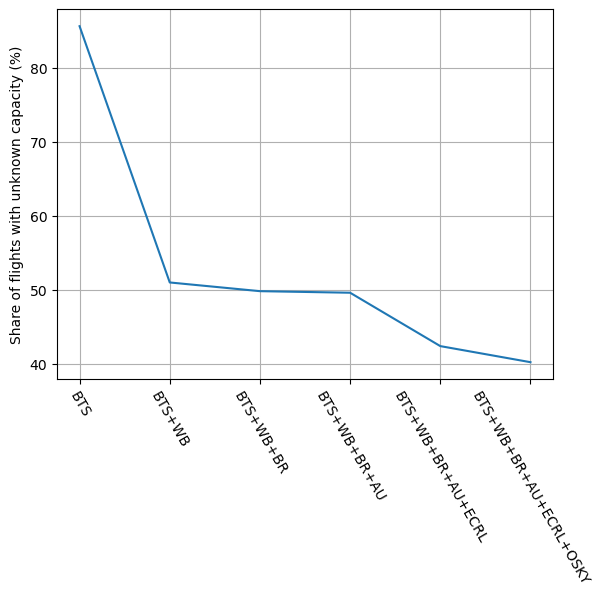

In [66]:
# Sample data
x_labels = ['BTS','BTS+WB', 'BTS+WB+BR', 'BTS+WB+BR+AU', 'BTS+WB+BR+AU+ECRL','BTS+WB+BR+AU+ECRL+OSKY']
y_values = [bts_only, bts_wb, bts_wb_br, bts_wb_br_au, bts_ectrl_wb_br_au, all_sce]

# Create the line plot with tilted x-axis labels
sns.lineplot(x=x_labels, y=y_values, markers=True)
plt.ylabel('Share of flights with unknown capacity (%)')
plt.xticks(rotation=-60)  # Set x-axis label rotation to 45 degrees
plt.grid()

In the end, we have seat data for 60% of the routes in the wiki DB! 
This is pretty interesting.  
Opensky db is only marginally interesting when already using eurocontrol and world bank data.  
Same remark for Australian and Brasilian sources, but theyr are very important since they will add diversity for the machine learning in the second notebook.

In [67]:
routes_with_bts_ecrl_os_wb_br_au['consolidated_seats'].sum()

3631602430.4930377

## Saving the database before estimation


In [68]:
routes_with_bts_ecrl_os_wb_br_au.to_csv('data/routes_processed_26_09.csv')